In [ ]:
# default_exp datasets

# Datasets

> Datasets for recognizing invidual dolphins from images


In [ ]:
# export

from pathlib import Path
from typing import *

In [ ]:
# exporti


import numpy as np
import shutil
from datetime import datetime
import torch
import torch.utils.data
from torch.hub import download_url_to_file
import torchvision
import PIL
from PIL import Image
from zipfile import ZipFile
import random

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torchvision.transforms import functional as F
from torchvision.transforms import ToPILImage

from tempfile import TemporaryDirectory

from dolphins_recognition_challenge import utils

import git

In [ ]:
# hide

try:
    from nbdev.imports import IN_NOTEBOOK
except:
    IN_NOTEBOOK=False
    
from nbdev.showdoc import *


## Download and load dataset

In [ ]:
# #exporti

# # Download TorchVision repo to use some files from
# # references/detection

# if not Path("coco_utils.py").exists():

#     with TemporaryDirectory() as d:
#         vision_root = Path(d) / "vision"
        
#         git.repo.base.Repo.clone_from(url="https://github.com/pytorch/vision.git", to_path=vision_root)
#         assert vision_root.exists() and vision_root.is_dir()
        
#         detection_root = vision_root / "references" / "detection"
#         py_files = list(detection_root.glob("**/*.py"))
#         assert len(py_files) >= 7

#         for f_src in py_files:
#             f_dst = (Path(".") / f_src.name)
#             print(f"Copy: {f_src.resolve()} -> {f_dst.resolve()}")
#             shutil.copy(f_src, f_dst)
#             assert f_dst.exists() and not f_dst.is_dir()

# assert Path("engine.py").exists()
# assert Path("transforms.py").exists()
# assert Path("coco_utils.py").exists()

# # imports
# from engine import train_one_epoch, evaluate
# import transforms as T
# import utils


In [ ]:
# hide

for m in [np, torch, torchvision, PIL]:
    print(f"{m.__name__:12}: {m.__version__}")

numpy       : 1.18.5
torch       : 1.7.1
torchvision : 0.8.2
PIL         : 7.2.0


In [ ]:
#exporti

dataset_url = "https://s3.eu-central-1.amazonaws.com/ai-league.cisex.org/2020-2021/dolphins-instance-segmentation/dolphins_200_train_val.zip"

In [ ]:
#exporti

dataset_root = Path("./data/dolphins_200_train_val")
dataset_zip = dataset_root.parent / "dolphins_200_train_val.zip"

def _download_data_if_needed():

    dataset_zip.parent.mkdir(parents=True, exist_ok=True)

    if not dataset_zip.exists():
        torch.hub.download_url_to_file(
            dataset_url,
            dataset_zip,
            hash_prefix=None,
            progress=True,
        )


    with ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(dataset_root)


In [ ]:
# hide

_download_data_if_needed()

assert dataset_root.exists() and dataset_root.is_dir()

train_images_path = dataset_root / "Train" / "JPEGImages"
train_instance_path = dataset_root / "Train" / "SegmentationObject"
train_class_path = dataset_root / "Train" / "SegmentationClass"

image_files = sorted([x for x in train_images_path.glob("**/*")])
assert len(image_files) >= 160, f"{len(image_files)}"

instance_files = sorted([x for x in train_instance_path.glob("**/*")])
assert len(instance_files) >= 160

class_files = sorted([x for x in train_class_path.glob("**/*")])
assert len(class_files) >= 160

In [ ]:
# exporti


def _enumerate_colors_for_fname(fname: Path) -> Tuple[int, int, int]:
    """Finds all colors in the image"""
    img = Image.open(fname)
    colors = [y for x, y in img.getcolors()]
    return colors

In [ ]:
# hide

test_file = train_class_path / "070624_6_1_0022.png"

actual = _enumerate_colors_for_fname(test_file)

expected = [(255, 0, 0), (0, 0, 0)]
assert actual == expected, f"{actual} == {expected}"

In [ ]:
# exporti


def _enumerate_colors_for_fnames(fnames: List[Path]) -> Dict[Tuple[int, int, int], int]:
    """This function is used to pin (0, 0, 0) color to the front of palette"""
    colors = np.array([_enumerate_colors_for_fname(fname) for fname in fnames]).reshape(
        -1, 3
    )
    colors = set([tuple(x) for x in colors.tolist() if tuple(x) != (0, 0, 0)])
    colors = [(0, 0, 0)] + list(colors)
    return {x: i for i, x in enumerate(colors)}

In [ ]:
# hide

actual = _enumerate_colors_for_fnames(class_files)

expected = {(0, 0, 0): 0, (255, 0, 0): 1}

assert actual == expected, f"{actual} == {expected}"

In [ ]:
# exporti


def _substitute_values(xs: np.array, x, y):
    """Not sure I understand what this does"""
    ix_x = xs == x
    ix_y = xs == y
    xs[ix_x] = y
    xs[ix_y] = x

In [ ]:
# exporti


def _enumerate_image_for_instances(
    im: Image, force_black_to_zero: bool = True, max_colors=16
) -> np.array:
    """convert rgb image mask to enumerated image mask"""
    pallete_mask = im.convert("P", palette=Image.ADAPTIVE, colors=max_colors)

    xs = np.array(pallete_mask)

    if force_black_to_zero:
        _substitute_values(xs, 0, xs.max())

    return xs

In [ ]:
# hide

enum_instance = _enumerate_image_for_instances(Image.open(instance_files[0]))
assert enum_instance.shape == (500, 750)

unique_enum_instance = np.unique(np.array(enum_instance))
assert sorted(unique_enum_instance) == [0, 1, 2] # for this particular photo

In [ ]:
# exporti


def _enumerate_image_for_classes(
    im: Image,
    colors: Dict[Tuple[int], int] = None,
) -> np.array:
    """Enumerates classes from the rbg format"""
    xs = np.array(im)
    xs = [
        ((xs == color).all(axis=-1)).astype(int) * code
        for color, code in colors.items()
    ]
    xs_sum = xs[0]
    for i in range(1, len(xs)):
        xs_sum = xs_sum + xs[i]
    return xs_sum.astype("uint8")

In [ ]:
# hide

class_palette = _enumerate_colors_for_fnames(class_files)
assert class_palette == class_palette

img = Image.open(class_files[0])

enum_classes = _enumerate_image_for_classes(img, class_palette)
assert enum_classes.shape == (500, 750)

unique_enum_classes = np.unique(enum_classes)
assert set(unique_enum_classes) == {0, 1}, f"{unique_enum_classes}"

In [ ]:
# exporti


class DolphinsInstanceSegmentationDataset(torch.utils.data.Dataset):
    """Instance segmentation dataset"""

    def __init__(
        self,
        root: Path,
        tensor_transforms: Optional[Callable[[Image.Image], Any]]=None,
        n_samples: int=-1
    ):
        self.root = root
        self.tensor_transforms = tensor_transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.img_paths = sorted((root / "JPEGImages").glob("*.*"))[:n_samples]
        self.label_paths = sorted((root / "SegmentationClass").glob("*.*"))[:n_samples]
        self.mask_paths = sorted((root / "SegmentationObject").glob("*.*"))[:n_samples]

        self.class_colors = _enumerate_colors_for_fnames(self.label_paths)

    def __getitem__(self, idx):

        # load images ad masks
        img_path = self.img_paths[idx]
        label_path = self.label_paths[idx]
        mask_path = self.mask_paths[idx]

        # load and transform images and masks
        img = Image.open(img_path).convert("RGB")
        mask_img = Image.open(mask_path)
        label_img = Image.open(label_path)

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = _enumerate_image_for_instances(mask_img)

        # instances are encoded as different colors
        obj_ids = np.unique(mask)

        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        label_array = _enumerate_image_for_classes(label_img, self.class_colors)
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        labels = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

            class_mask = label_array * masks[i]
            label, count = np.unique(class_mask, return_counts=True)
            assert label.shape[0] <= 2
            label = max(label)
            labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there WAS multi class
        # labels = torch.as_tensor(labels, dtype=torch.int64)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.tensor_transforms is not None:
            img, target = self.tensor_transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_paths)

(<PIL.Image.Image image mode=RGB size=750x500 at 0x7F52733648D0>,
 {'boxes': tensor([[539., 236., 734., 320.],
          [301., 248., 554., 339.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([16380., 23023.]),
  'iscrowd': tensor([0, 0])})

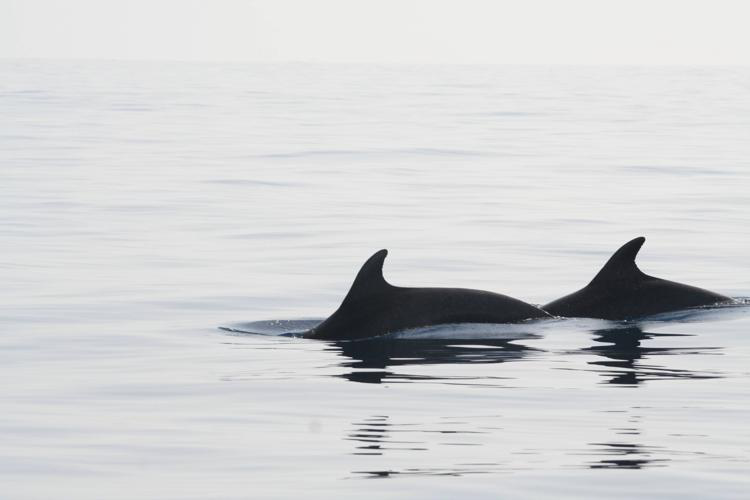

In [ ]:
# hide

# The simplest way to generate a dataset is just to create it without any transformation. The result will be a pair where the first item is Image and the second is dictionary with target data (tensors defining output masks).

dataset = DolphinsInstanceSegmentationDataset(dataset_root / "Train")
sample = dataset[0] 

display(sample)
display(sample[0])

In [ ]:
#export

class ToTensor(object):
    """ Transforms an object (image) into a Tensor
    """
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

In [ ]:
# exporti

def _get_tensor_transforms(train: bool):
    return ToTensor()


def _get_instance_segmentation_dataset(
    *,
    get_tensor_transforms: Callable[
        [bool], Callable[[Image.Image], Any]
    ] = _get_tensor_transforms,
    batch_size: int = 4,
    num_workers: int = 4,
    n_samples: int=-1,
) -> Tuple[
    torch.utils.data.dataloader.DataLoader, torch.utils.data.dataloader.DataLoader
]:
    """Get dataset for instance segmentation. Make sure you define get_transform function."""

    # get data if needed
    _download_data_if_needed()
    root_path = Path(dataset_root)
    assert root_path.exists()
    assert root_path.is_dir()
    assert len(list(root_path.glob("**/*"))) >= 600

    # use our dataset and defined transformations
    dataset = DolphinsInstanceSegmentationDataset(
        dataset_root / "Train",
        tensor_transforms=get_tensor_transforms(train=True),
        n_samples=n_samples
    )
    dataset_test = DolphinsInstanceSegmentationDataset(
        dataset_root / "Val",
        tensor_transforms=get_tensor_transforms(train=False),
        n_samples=n_samples
    )

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=utils.collate_fn,
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=utils.collate_fn,
    )

    return data_loader, data_loader_test

In [ ]:
# export

def stack_imgs(imgs: List[PIL.Image.Image], width: int=None) -> PIL.Image:
    """ Stacks images horizontaly in one large image. Very useful for debugging purposes.
    """
    height = max([img.size[1] for img in imgs])
    imgs = [np.array(img.resize((img.size[0], height))) for img in imgs]
    imgs = np.hstack(imgs)
    img = Image.fromarray(imgs)
    if width:
        height = int(img.size[1] * width / img.size[0])
        img = img.resize((width, height))
    return img

In [ ]:
#hide

dataset = DolphinsInstanceSegmentationDataset(dataset_root / "Train")
sample = dataset[0]

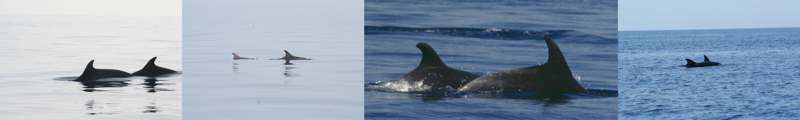

In [ ]:
imgs = [img for img, _ in dataset]

stack_imgs(imgs[:4]).resize((800, 120))

In [ ]:
# export

def display_batches(data_loader: torch.utils.data.DataLoader, *, n_batches: int=1, width:int=800, show_y: bool=False):
    """ Displays `n_batches`, one batch per row.
    """
    to_pil_img = ToPILImage()
    for i, (x, y) in enumerate(data_loader):
        if i >= n_batches:
            return
        if isinstance(x[0], torch.Tensor):
            x = [to_pil_img(t) for t in x]
        display(stack_imgs(x, width=width))
        if show_y:
            display(y)

In [ ]:
#hide

data_loader, data_loader_val = _get_instance_segmentation_dataset(batch_size=2)

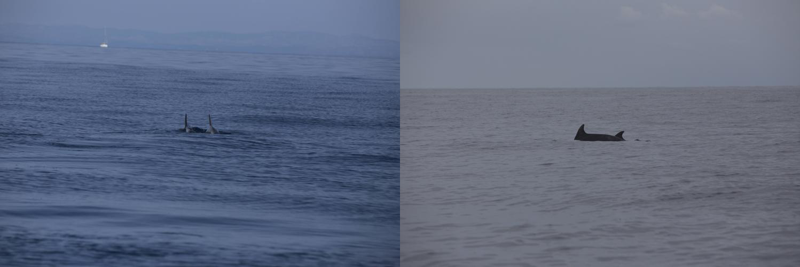

In [ ]:
display_batches(data_loader)

In [ ]:
# export

def get_image2tensor_transforms(train: bool):
    """ Converts image to tensor
    """
    return ToTensor()

def get_dataset(
    name: str,
    *,
    get_tensor_transforms: Callable[[bool], Callable[[Image.Image], Any]] = get_image2tensor_transforms,
    batch_size: int = 4,
    num_workers: int = 4,
    n_samples: int=-1,
) -> Tuple[
    torch.utils.data.dataloader.DataLoader, torch.utils.data.dataloader.DataLoader
]:
    """Get one of two datasets available. The parameter `name` can be one of 'segmentation' and 'classification'"""

    assert name in [
        "segmentation",
        "classification",
    ], f"name should be either 'segmentation' or 'classification', but it is '{name}'."

    if name == "segmentation":
        return _get_instance_segmentation_dataset(
            get_tensor_transforms=get_tensor_transforms,
            batch_size=batch_size,
            num_workers=num_workers,
            n_samples=n_samples,
        )
    elif name == "classification":
        raise NotImplementedError()

When create dataset loaders, we must pass two functions returning transformations on an image and on tensors.

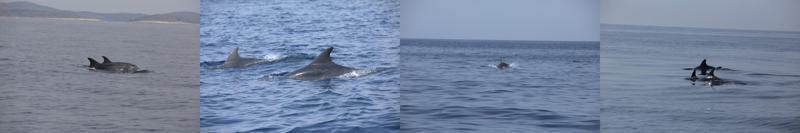

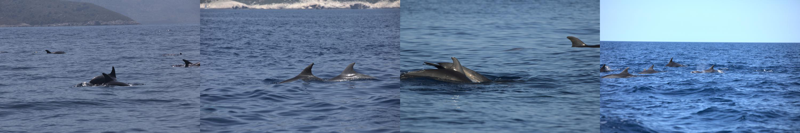

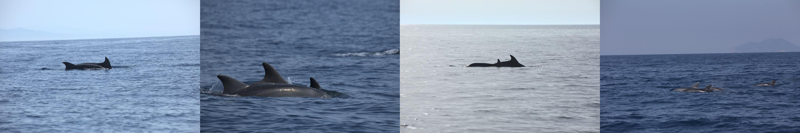

In [ ]:
data_loader, data_loader_val = get_dataset("segmentation", batch_size=4)

display_batches(data_loader, n_batches=3)

## Data augmentation



In order to prevent overfitting which happens when the dataset size is too small, we perform a number of transformations to increase the size of the dataset. One transofrmation implemented in the Torch vision library is `RandomHorizontalFlip` and we will implemented `MyColorJitter` which is basically just a wrapper around `torchvision.transforms.ColorJitter` class. However, we cannot use this class directly without a wrapper because a transofrmation could possibly affect targets and not just the image. For example, if we were to implement RandomCrop, we would need to crop segmentation masks and readjust bounding boxes as well.

In [ ]:
#exporti

def _flip_coco_person_keypoints(kps, width):
    flip_inds = [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    flipped_data = kps[:, flip_inds]
    flipped_data[..., 0] = width - flipped_data[..., 0]
    # Maintain COCO convention that if visibility == 0, then x, y = 0
    inds = flipped_data[..., 2] == 0
    flipped_data[inds] = 0
    return flipped_data


In [ ]:
#export

class Compose(object):
    """ Compose a list of transformations into one transformation
    """
    def __init__(self, transforms: List):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    """ Randomly flips image horizontally
    """
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


In [ ]:
show_doc(ToTensor)

<h2 id="ToTensor" class="doc_header"><code>class</code> <code>ToTensor</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>ToTensor</code>()

Transforms an object (image) into a Tensor
    

This is an example on how to construct `get_tensor_transforms` needed to construct a `data_loader` object using `get_dataset` function:

In [ ]:
class MyColorJitter:
    def __init__(self, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5):
        self.torch_color_jitter = torchvision.transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue
        )

    def __call__(self, image, target):
        image = self.torch_color_jitter(image)
        return image, target
    
def get_my_tensor_transforms(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(MyColorJitter())
        # TODO: add additional transforms: e.g. random crop
    return Compose(transforms)

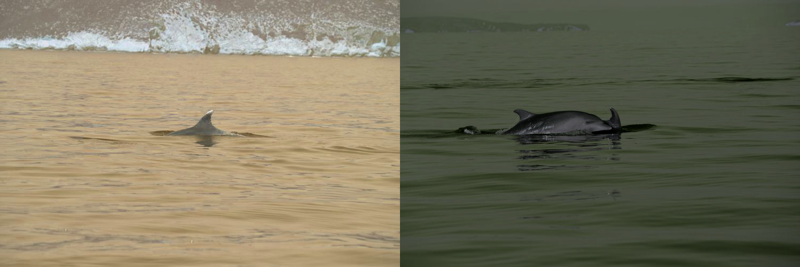

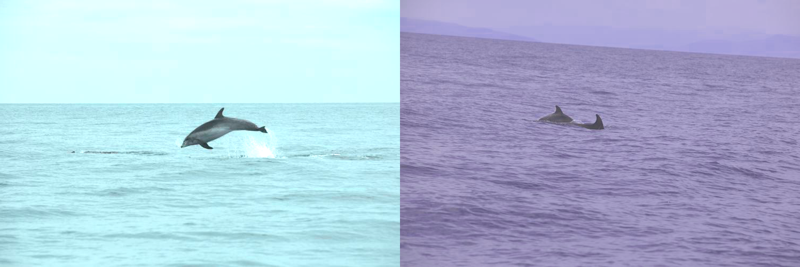

In [ ]:
data_loader, data_loader_test = get_dataset("segmentation", batch_size=2, get_tensor_transforms=get_my_tensor_transforms)

display_batches(data_loader, n_batches=2)

> Tip: incorporate more transformation classes such as `ColorJitter` and `RandomCrop` etc. (https://pytorch.org/docs/stable/torchvision/transforms.html)